# TTC Delay Analysis

I've personally experienced many painful delays while traveling to work on the TTC and finally motivated myself to understand the how and why they happen. The data was surprisingly easy to obtain as the Ontario government is pretty transparent on public transportation information. The data is available in the TTC Project folder and can also be found with the following link (https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/). Keep in mind that I've renamed the files as they were named inconsistently and it would make it easier to combine.


In [1]:
# Essential libraries for math operations and visualizations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# Machine learning libraries

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint
from datetime import datetime, date, time 

Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Lets look at a small slice of our data to see what features and data types we have available to us

In [2]:
df = pd.read_excel('SubwaySRTLogs201805.xlsx')
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-05-01,00:18,Tuesday,OLD MILL STATION,MUI,9,13,W,BD,5077
1,2018-05-01,00:29,Tuesday,YUS/BD/SHEPPARD SUBWAY,TUO,0,0,W,BD,5234
2,2018-05-01,02:01,Tuesday,MCCOWAN YARD,PRSP,0,0,N,SRT,3015
3,2018-05-01,02:41,Tuesday,VAUGHAN MC STATION,SUO,0,0,NaN,YU,0
4,2018-05-01,05:47,Tuesday,KIPLING STATION,MUSC,0,0,E,BD,5120


Now that we get a picture of what our tables look like, we will now combine all the data using regular expression to select the appropriate files. Note that this was why we renamed the files earlier. The result will be a table with a shape of (99479, 10).



In [3]:
regex = re.compile(r'SubwaySRTLogs.*')
files = os.listdir('.')
file = filter(regex.search, files)

all_data = pd.DataFrame()
for datafile in file:
    df = pd.read_excel(datafile)
    all_data = all_data.append(df)
    
all_data.shape
#stringColumns = ['Day', 'Station', 'Code', 'Bound', 'Line', 'Vehicle']
#all_data[stringColumns] = all_data[stringColumns].astype(str) 

(99479, 10)

## Data Cleansing

Now that the data has been combined we will clean as much of it as we can before we split it into training and testing sets. We first look at how much data is missing in the resulting table and will decide on whether or not we throw it out or impute it. 

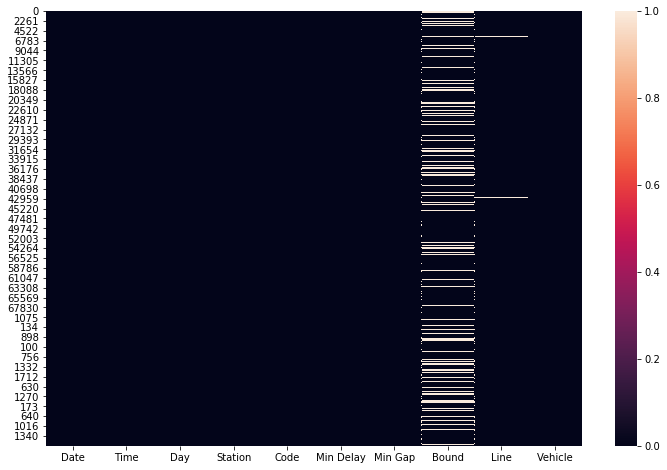

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(all_data.isnull())

In [5]:
# Remove SRT data
all_data = all_data[(all_data['Line'] != 'SRT') & 
        (all_data['Bound'].notnull()) & 
        (all_data['Line'].notnull())]

# Remove inconsistent Station names
bad_names = all_data['Station'].value_counts()[all_data['Station'].value_counts() <250].index
all_data = all_data[~all_data['Station'].isin(bad_names)]

# Remove inconsistent Line names
good_names = all_data['Line'].value_counts().head(2).index
all_data = all_data[all_data['Line'].isin(good_names)]

# Remove non sensical Bound directions
good_names2 = all_data.Bound.value_counts().head(4).index
all_data = all_data[all_data['Bound'].isin(good_names2)]

We end up seeing a lot of missing data for Bound and a few for Line so we will remove all of it and any data related to the SRT line. The reason being is because we want to focus on delays near the downtown core and the SRT data will only muddy our predictive model. There were also inconsistent naming conventions fouund in the Station, Line, and Bound columns so we will remove those as well.

# Feature Engineering

Now we start creating some features based on our knowledge around how the subway operates

In [6]:
# This column will be a boolean value representing whether there is a delay or not. It will also be our y-value 
all_data['Delay'] = all_data['Min Delay'].apply(lambda x: x>0) * 1

In [7]:
# These columns will be boolean values representing whether or not its rush hour. Rush hour is assumed to 
# be between 6:30 - 10:00 and 15:30 - 19:00
all_data['Time'] = all_data['Time'].apply(lambda x: int(x.replace(':', '')))
all_data['MorningRush'] = all_data['Time'].apply(lambda x: 630 <= x <= 1000)*1
all_data['AfternoonRush'] = all_data['Time'].apply(lambda x: 1530 <= x <= 1900)*1

# Exploratory Data Analysis

Now that our data can be considered clean, we will start plotting some of the data to see if we can find anything interesting

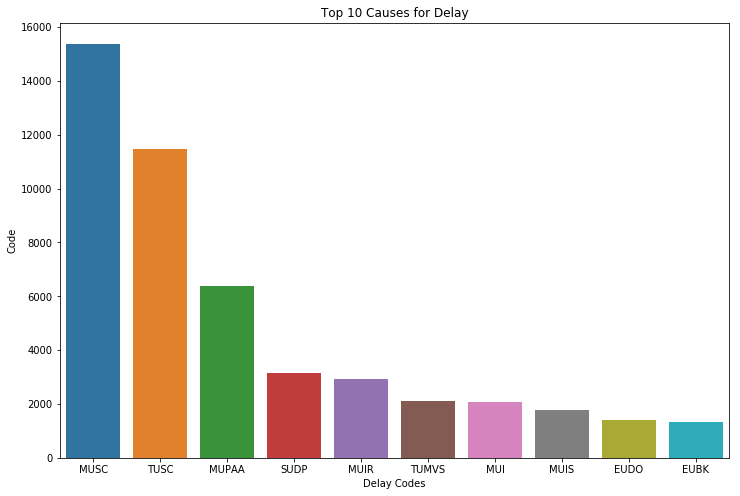

In [8]:
delayCodes = all_data['Code'].value_counts().head(10)
plt.figure(figsize=[12,8])

plt.title('Top 10 Causes for Delay')
plt.xlabel('Delay Codes')
plt.ylabel('Number of Occurences')
sns.barplot(x=delayCodes.index, y=delayCodes)


Interestingly enough 46.6% of Delays are speed related. The rest of the codes can be seen below


MUSC  -  Miscellaneous Speed Control 
TUSC  -  Operator Overspeeding    
MUPAA  - Passenger Assistance Alarm Activated - No Trouble Found  
MUIS  -  Injured or ill Customer (In Station) - Transported  
MUGD  -  Miscellaneous General Delays      
MUO  -   Miscellaneous Other       
SUDP  -  Disorderly Patron      
MUIR -   Injured or ill Customer (On Train) - Medical Aid Refused     
MUI  -   Injured or ill Customer (On Train) - Transported     
TUMVS  -  Operator Violated Signal



Text(0,0.5,'Total Minutes')

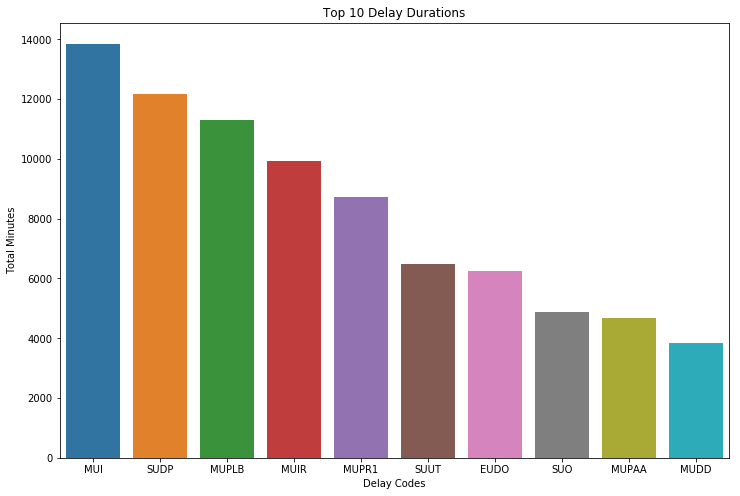

In [9]:
delayTimes = (all_data.groupby('Code')['Min Delay']
                      .sum()
                      .sort_values(ascending=False)
                      .head(10))

plt.figure(figsize=[12,8])


sns.barplot(x=delayTimes.index, y=delayTimes)
plt.title('Top 10 Delay Durations')
plt.xlabel('Delay Codes')
plt.ylabel('Total Minutes')

Most time consuming delays are related to disorderly and injured passengers

MUI - Injured or ill Customer (On Train) - Transported        
SUDP - Disorderly Patron        
MUPLB - Fire/Smoke Plan B - Source TTC        
MUIR - Injured or ill Customer (On Train) - Medical Aid Refused        
MUPR1 - Priority One - Train in Contact With Person        
SUUT - Unauthorized at Track Level        
EUDO - Door Problems - Faulty Equipment        
SUO - Passenger Other        
MUPAA - Passenger Assistance Alarm Activated - No Trouble Found        
MUDD - Door Problems - Debris Related        


Text(0,0.5,'Amount of Delays')

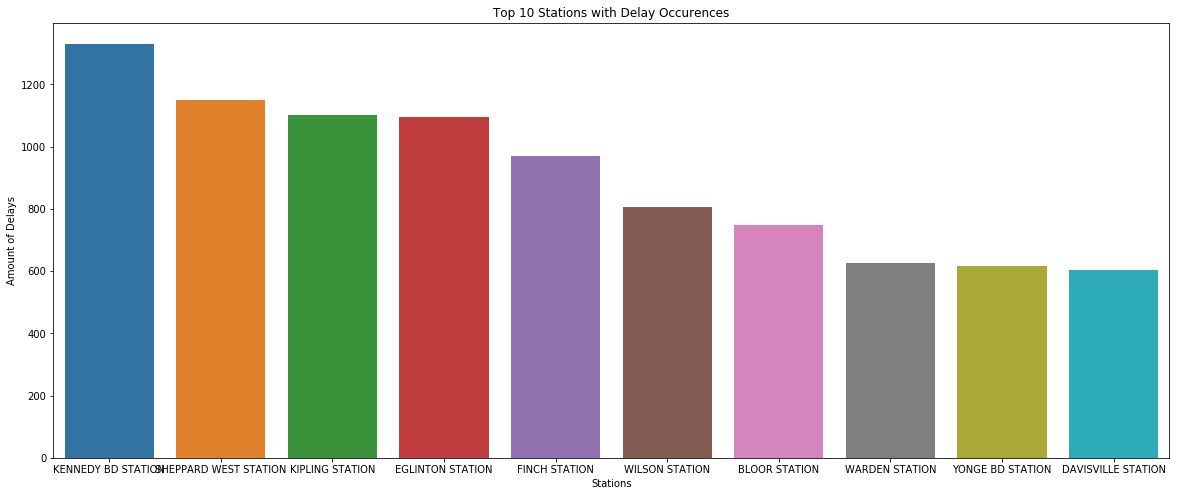

In [19]:

delayOccurences = (all_data[all_data['Min Delay']>0].groupby('Station')['Min Delay']
                                                   .count()
                                                   .sort_values(ascending=False)
                                                   .head(10))
plt.figure(figsize=[20,8])
sns.barplot(x=delayOccurences.index, y=delayOccurences)
plt.title('Top 10 Stations with Delay Occurences')
plt.xlabel('Stations')
plt.ylabel('Amount of Delays')

Interestingly the three stations with the most amount of delay occurences are the ones farthest from the downtown core. Kennedy and Kipling being on line 2 and Sheppard West Station being on line 1

# Preprocessing

This step will involve converting columns with strings into a nuumerical representation and splitting the data into training and testing data

In [21]:
stringColumns = ['Day', 'Station', 'Bound', 'Line']
all_data = pd.get_dummies(all_data, columns=stringColumns)


In [22]:
all_data = all_data.drop(['Date', 'Time', 'Code', 'Min Delay', 'Min Gap', 'Vehicle'], axis=1)
X = all_data.drop('Delay', axis=1)
y = all_data['Delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Modeling

Now we will be experimenting to see which classifier model performs the best and use hyperparameter tuning to identify the best parameters for the model.

In [27]:
# Function for hyperparameter tuning

def tuning(m):
    if m=='knn':
        model_cv = GridSearchCV(model, param_grid, cv=5)
        model_cv.fit(X_train, y_train)
    elif m=='logreg':
        model_cv = GridSearchCV(model, param_grid, cv=5)
        model_cv.fit(X_train, y_train) 
    elif m=='tree': 
        model_cv = RandomizedSearchCV(model, param_grid, cv=5)
        model_cv.fit(X_train, y_train)
    elif m=='svm':
        model_cv = GridSearchCV(model, param_grid, cv=3)
        model_cv.fit(X_train, y_train)
        
    else:
        return print('ERROR: There was a problem with the parameter input')
    print("Tuned Parameters: {}".format(model_cv.best_params_)) 
    print("Best score is {}".format(model_cv.best_score_))


### Logisitic Regression

In [26]:
model = LogisticRegression(C=0.265, penalty='l1')
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)

param_grid = {'C': np.logspace(-5, 1, 100), 'penalty': ['l1', 'l2']}

tuning('logreg')

Tuned Logistic Regression Parameters: {'C': 0.26560877829466895, 'penalty': 'l1'}
Best score is 0.6598894051849205


### Random Forest

In [31]:
model_tree = RandomForestClassifier(criterion='gini', max_depth= None, max_features=7, min_samples_leaf=7)
model_tree.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)

param_grid = {"max_depth": [3, None],
              "max_features": randint(1, 10),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tuning('tree')

Tuned Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 6}
Best score is 0.66001555896638


### KNearestNeighbor

In [29]:
model = KNeighborsClassifier(n_neighbors=8)
model.fit(X_train, y_train)
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)

param_grid = {'n_neighbors': range(3,15)}

tuning('knn')

Tuned Parameters: {'n_neighbors': 14}
Best score is 0.6479888984672315


It looks like the Random Forest Classifier performed the best so we'll test it on the testing data

# Result

In [32]:
print(accuracy_score(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print(confusion_matrix(y_test, y_pred))

0.6564074105694527


             precision    recall  f1-score   support

          0       0.67      0.92      0.78     15276
          1       0.52      0.17      0.26      8150

avg / total       0.62      0.66      0.60     23426



[[13985  1291]
 [ 6758  1392]]


In conclusion, we were created a model a that is able to predict TTC delays approximately 66% of the time correctly. The most interesting thing to me that the most common reason for a delay was speed related. A possible solution to this is to have the trains operated by AI with human supervision so that there is less human error involved.  